In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")

# Load file
walmart = pd.read_excel("walmart.xlsx", engine='openpyxl')

# Preview 
walmart.head()

# Check shape and column types
walmart.info()

# Summary stats
walmart.describe()

# missing data
walmart.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6118 entries, 0 to 6117
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6118 non-null   datetime64[ns]
 1   Year       6118 non-null   int64         
 2   Month      6118 non-null   object        
 3   Day        6118 non-null   object        
 4   Open       6118 non-null   float64       
 5   High       6118 non-null   float64       
 6   Low        6118 non-null   float64       
 7   Close      6118 non-null   float64       
 8   Adj Close  6118 non-null   float64       
 9   Volume     6118 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 478.1+ KB


Date         0
Year         0
Month        0
Day          0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

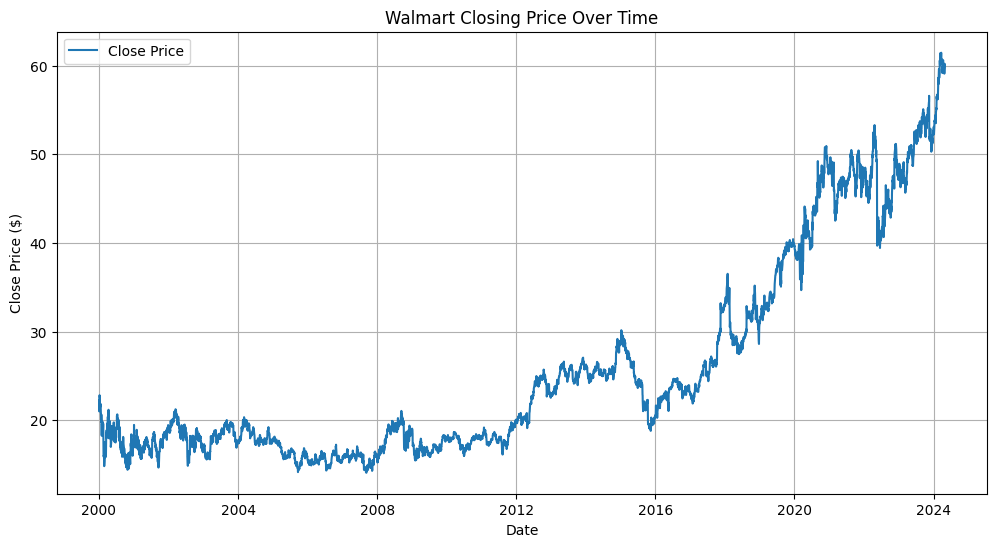

In [25]:
# closing price over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(walmart['Date'], walmart['Close'], label='Close Price')
plt.title('Walmart Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# calculating daily returns to measure the % change in price from one day to the next
# Create a new column for daily return
walmart['Daily_Return'] = walmart['Adj Close'].pct_change()

# preview the new column
walmart[['Date', 'Adj Close', 'Daily_Return']].head()


,Date,Adj Close,Daily_Return
0,2000-01-03,14.47,NaN
1,2000-01-04,13.93,-0.037319
2,2000-01-05,13.64,-0.020818
3,2000-01-06,13.79,0.010997
4,2000-01-07,14.83,0.075417


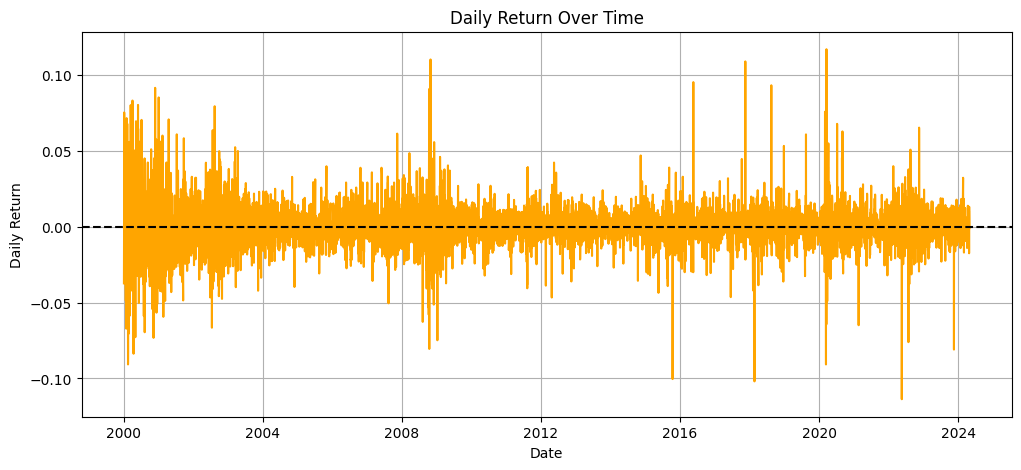

In [27]:
# plotting daily returns to visualize the volatility and detect outlier days
plt.figure(figsize=(12, 5))
plt.plot(walmart['Date'], walmart['Daily_Return'], color='orange')
plt.title('Daily Return Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.axhline(0, color='black', linestyle='--')
plt.show()

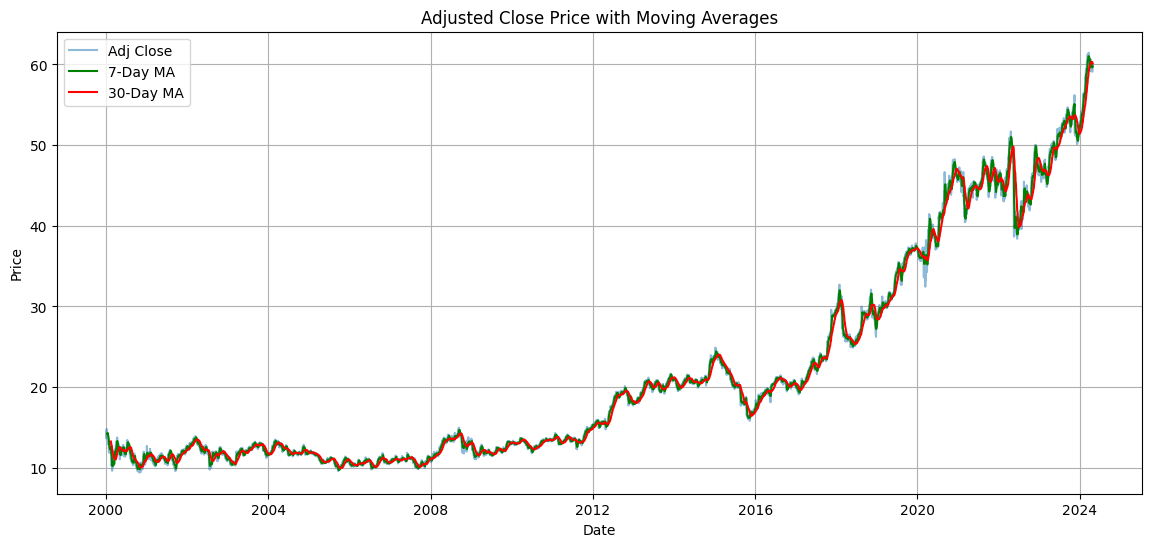

In [28]:
# smoothing price data using a rolling mean
# 7-day and 30-day moving averages
walmart['MA7'] = walmart['Adj Close'].rolling(window=7).mean()
walmart['MA30'] = walmart['Adj Close'].rolling(window=30).mean()

# Plot the moving averages along with the adjusted close
plt.figure(figsize=(14, 6))
plt.plot(walmart['Date'], walmart['Adj Close'], label='Adj Close', alpha=0.5)
plt.plot(walmart['Date'], walmart['MA7'], label='7-Day MA', color='green')
plt.plot(walmart['Date'], walmart['MA30'], label='30-Day MA', color='red')
plt.title('Adjusted Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


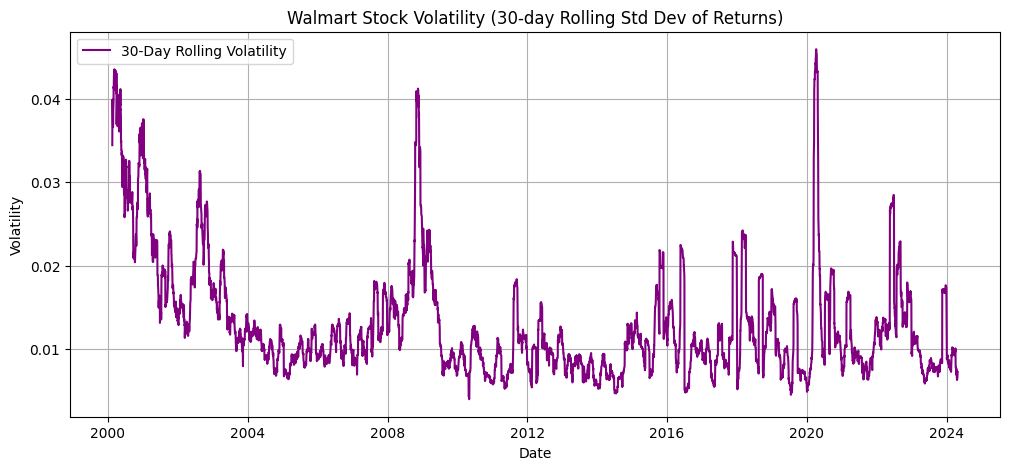

In [29]:
# volatility analysis
# 30-day rolling standard deviation (volatility)
walmart['Volatility'] = walmart['Daily_Return'].rolling(window=30).std()

plt.figure(figsize=(12, 5))
plt.plot(walmart['Date'], walmart['Volatility'], label='30-Day Rolling Volatility', color='purple')
plt.title('Walmart Stock Volatility (30-day Rolling Std Dev of Returns)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.legend()
plt.show()

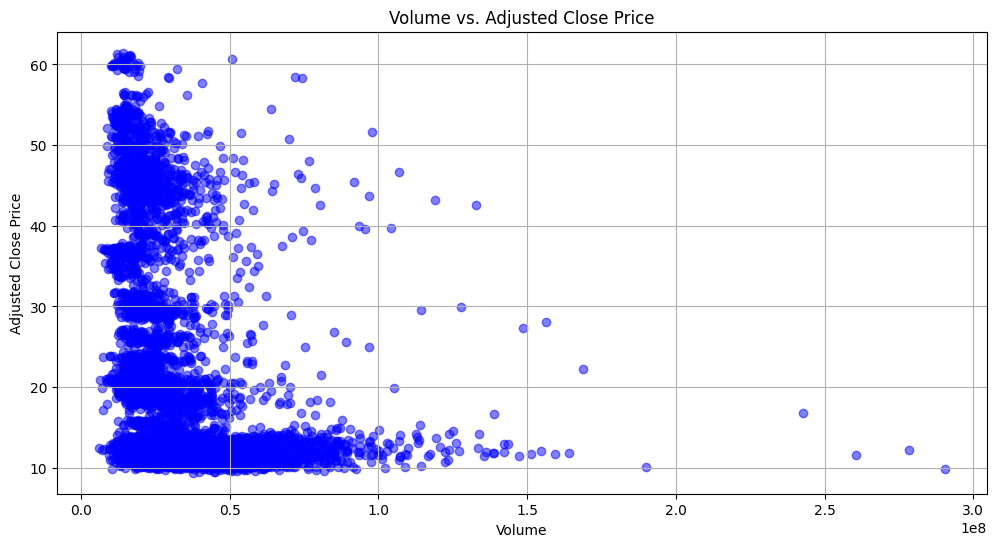

In [30]:
# vol vs price
plt.figure(figsize=(12, 6))
plt.scatter(walmart['Volume'], walmart['Adj Close'], alpha=0.5, c='blue')
plt.title('Volume vs. Adjusted Close Price')
plt.xlabel('Volume')
plt.ylabel('Adjusted Close Price')
plt.grid(True)
plt.show()


In [31]:
%pip install nbformat

# candlestick chart for OHLC visualization: interactive chart
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=walmart['Date'],
                open=walmart['Open'],
                high=walmart['High'],
                low=walmart['Low'],
                close=walmart['Close'])])

fig.update_layout(title='Walmart Stock Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  xaxis_rangeslider_visible=False)


fig.show() #install nbformat

Note: you may need to restart the kernel to use updated packages.


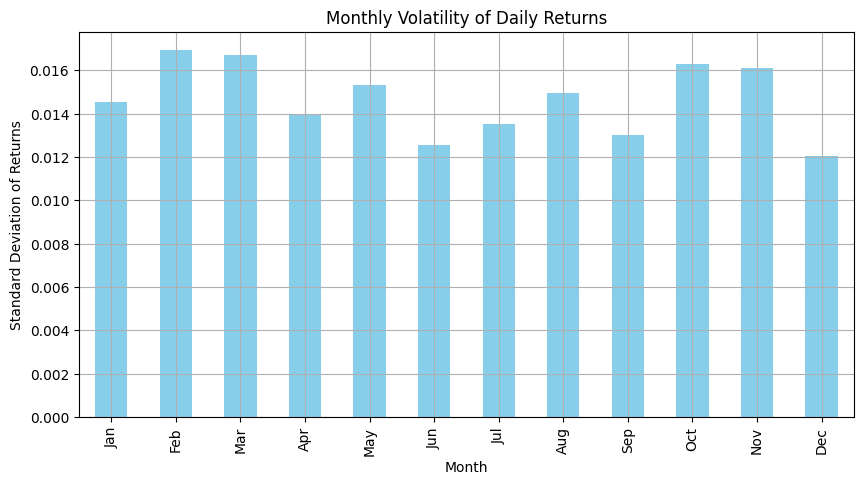

In [32]:
# seasonality checks: monthly volatility
# check which months are most volatile
# Ensure Month column is available
walmart['Month'] = pd.to_datetime(walmart['Date']).dt.month

# Calculate monthly volatility
monthly_volatility = walmart.groupby('Month')['Daily_Return'].std()

# Plot it
monthly_volatility.plot(kind='bar', color='skyblue', figsize=(10, 5))
plt.title('Monthly Volatility of Daily Returns')
plt.xlabel('Month')
plt.ylabel('Standard Deviation of Returns')
plt.xticks(ticks=range(0, 12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.grid(True)
plt.show()


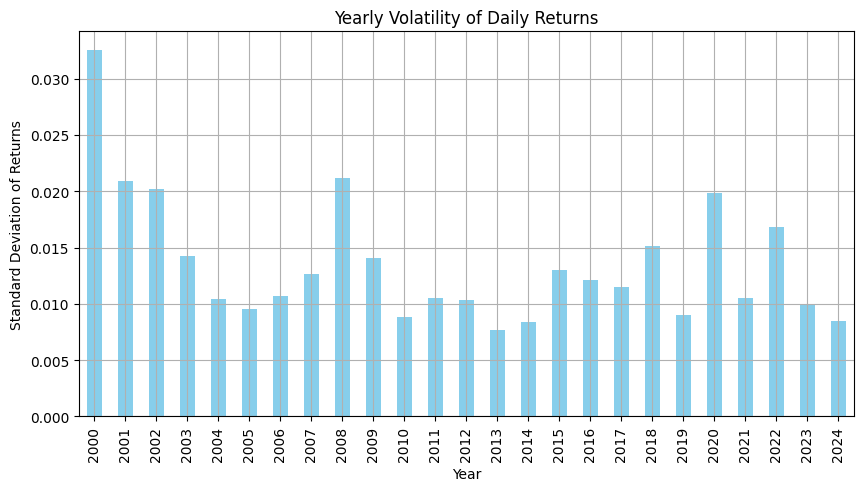

In [33]:
# seasonality checks: yearly volatility
# check which months are most volatile
# Ensure Month column is available
# Calculate monthly volatility
monthly_volatility = walmart.groupby('Year')['Daily_Return'].std()

# Plot it
monthly_volatility.plot(kind='bar', color='skyblue', figsize=(10, 5))
plt.title('Yearly Volatility of Daily Returns')
plt.xlabel('Year')
plt.ylabel('Standard Deviation of Returns')
plt.grid(True)
plt.show()


                Volume  Adj Close  Daily_Return
Volume        1.000000  -0.315441     -0.036282
Adj Close    -0.315441   1.000000      0.022100
Daily_Return -0.036282   0.022100      1.000000


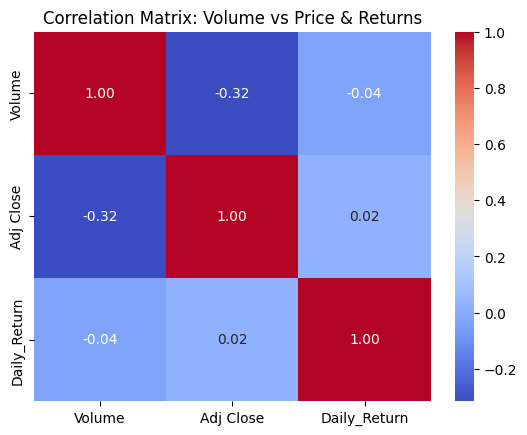

In [34]:
# correlation between volume, close and daily return
# Check correlation matrix
correlation = walmart[['Volume', 'Adj Close', 'Daily_Return']].corr()
print(correlation)

# Heatmap for visualization
import seaborn as sns
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Volume vs Price & Returns')
plt.show()

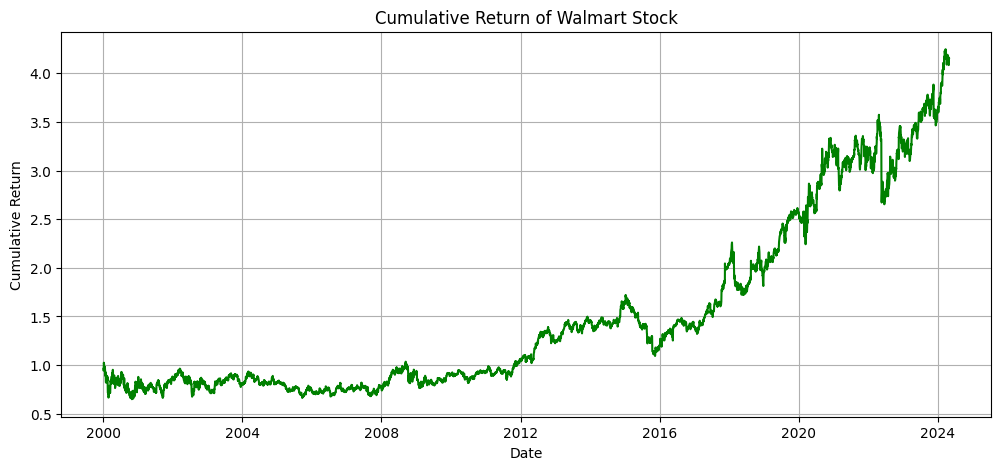

In [35]:
# return calculations: daily and monthly cumulative returns
# Already have Daily_Return
# Monthly return
walmart['YearMonth'] = walmart['Date'].dt.to_period('M')
monthly_returns = walmart.groupby('YearMonth')['Adj Close'].last().pct_change()

# Cumulative return
walmart['Cumulative_Return'] = (1 + walmart['Daily_Return']).cumprod()

# Plot cumulative return
plt.figure(figsize=(12, 5))
plt.plot(walmart['Date'], walmart['Cumulative_Return'], color='green')
plt.title('Cumulative Return of Walmart Stock')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()


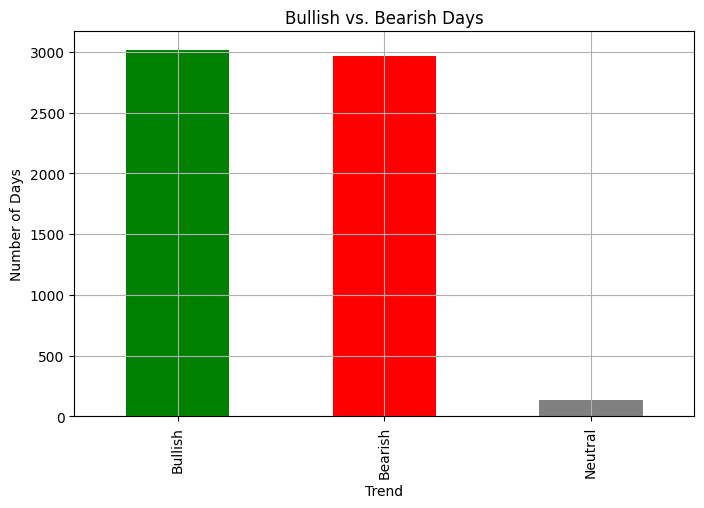

In [36]:
# Compare Open vs. Close – Bullish/Bearish Days
# Bullish = Close > Open, Bearish = Close < Open
walmart['Direction'] = walmart['Close'] - walmart['Open']
walmart['Trend'] = walmart['Direction'].apply(lambda x: 'Bullish' if x > 0 else 'Bearish' if x < 0 else 'Neutral')

# Count of days
trend_counts = walmart['Trend'].value_counts()

# Bar plot
trend_counts.plot(kind='bar', color=['green', 'red', 'gray'], figsize=(8, 5))
plt.title('Bullish vs. Bearish Days')
plt.ylabel('Number of Days')
plt.grid(True)
plt.show()


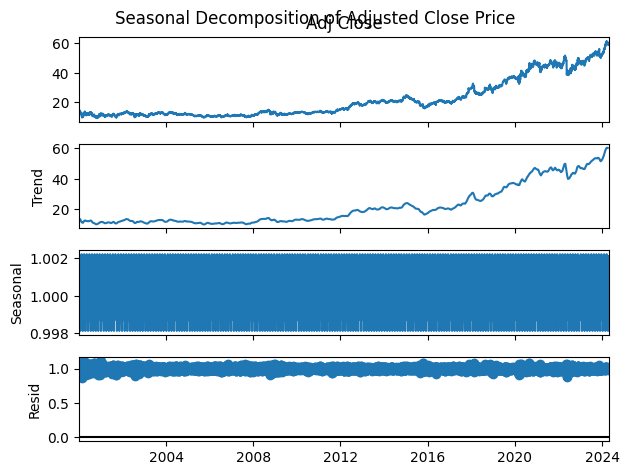

In [37]:
# time-series decomposition: break down the time series into trend, seasonality, and residuals
from statsmodels.tsa.seasonal import seasonal_decompose

# Set index as datetime for decomposition
walmart['Date'] = pd.to_datetime(walmart['Date'])
walmart.set_index('Date', inplace=True)

# Decompose the Adjusted Close
decomposition = seasonal_decompose(walmart['Adj Close'], model='multiplicative', period=30)
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Adjusted Close Price')
plt.show()

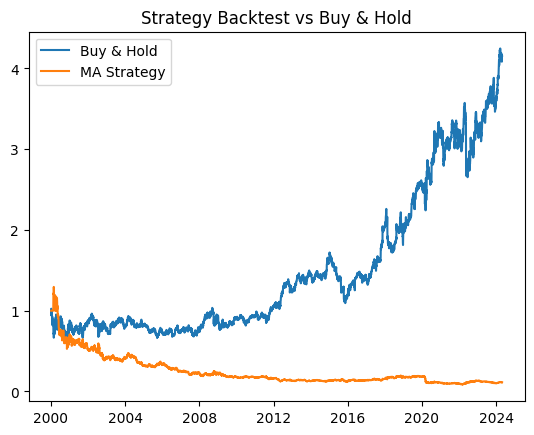

In [38]:
# BACKTESTING STRATEGY

walmart['MA7'] = walmart['Adj Close'].rolling(window=7).mean()
walmart['MA30'] = walmart['Adj Close'].rolling(window=30).mean()
walmart['Signal'] = 0
walmart.loc[walmart['MA7'] > walmart['MA30'], 'Signal'] = 1
walmart.loc[walmart['MA7'] < walmart['MA30'], 'Signal'] = -1
walmart['Daily_Return'] = walmart['Adj Close'].pct_change()
walmart['Strategy_Return'] = walmart['Signal'].shift(1) * walmart['Daily_Return']
walmart['Cumulative_Strategy'] = (1 + walmart['Strategy_Return']).cumprod()
walmart['Cumulative_Return'] = (1 + walmart['Daily_Return']).cumprod()

plt.plot(walmart['Cumulative_Return'], label='Buy & Hold')
plt.plot(walmart['Cumulative_Strategy'], label='MA Strategy')
plt.title('Strategy Backtest vs Buy & Hold')
plt.legend()
plt.show()

In [39]:
# PRICE PREDICTION CLASSIFICATION

# Adding RSI and MACD columns if not already present
if 'RSI' not in walmart.columns:
	walmart['RSI'] = RSIIndicator(close=walmart['Adj Close'], window=14).rsi()
if 'MACD' not in walmart.columns:
	macd = MACD(close=walmart['Adj Close'])
	walmart['MACD'] = macd.macd()

walmart['Target'] = (walmart['Adj Close'].shift(-1) > walmart['Adj Close']).astype(int)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD']
walmart.dropna(inplace=True)

X = walmart[features]
y = walmart['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.48      0.47       583
           1       0.51      0.50      0.50       635

    accuracy                           0.49      1218
   macro avg       0.49      0.49      0.49      1218
weighted avg       0.49      0.49      0.49      1218



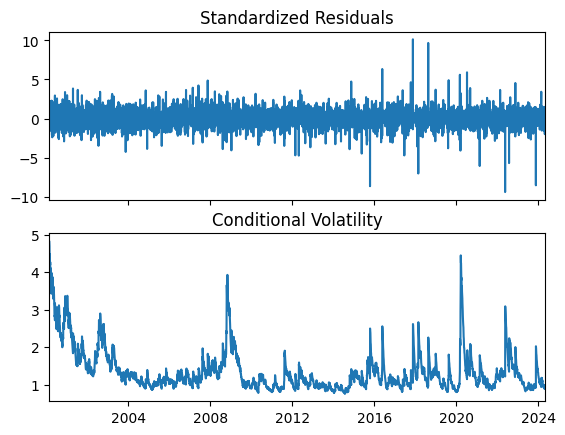

In [40]:
# VOLATILITY MODELING (GARCH)
returns = walmart['Daily_Return'].dropna() * 100
garch_model = arch_model(returns, vol='GARCH', p=1, q=1)
garch_res = garch_model.fit(disp='off')
garch_res.plot()
plt.show()

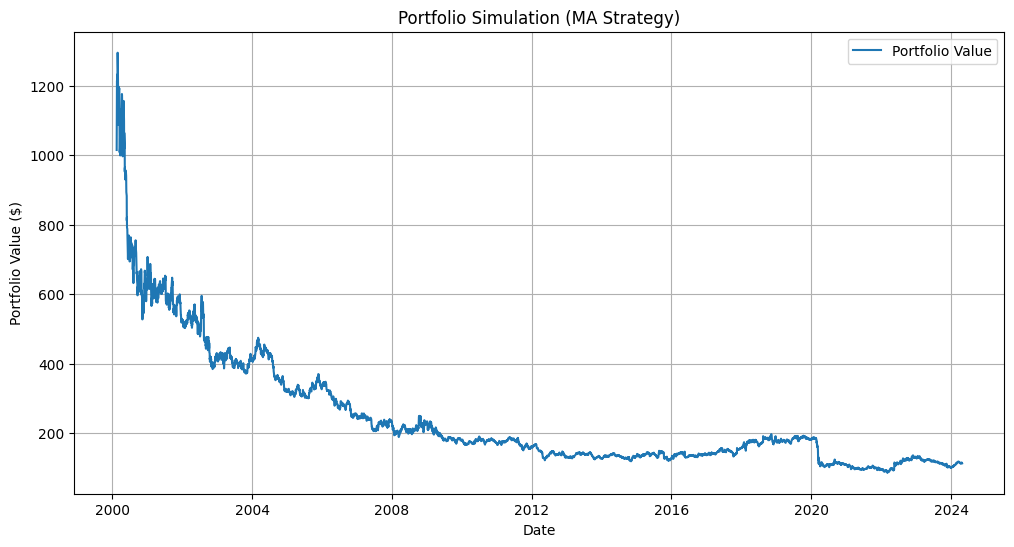

In [41]:
# PORTFOLIO SIMULATION
initial_capital = 1000
walmart['Portfolio_Value'] = initial_capital * walmart['Cumulative_Strategy']
plt.figure(figsize=(12, 6))
plt.plot(walmart['Portfolio_Value'], label='Portfolio Value')
plt.title('Portfolio Simulation (MA Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
# feature engineering
# Create lag features for ML models
for lag in range(1, 6):
    walmart[f"lag_{lag}"] = walmart['Adj Close'].shift(lag)

# Add numeric calendar features if index is DatetimeIndex
if isinstance(walmart.index, pd.DatetimeIndex):
    walmart['Day_num'] = walmart.index.day
    walmart['Month_num'] = walmart.index.month
    walmart['Weekday_num'] = walmart.index.weekday

# Add technical indicators
walmart['RSI'] = RSIIndicator(walmart['Adj Close']).rsi()
walmart['MACD'] = MACD(walmart['Adj Close']).macd()
bb = BollingerBands(walmart['Adj Close'])
walmart['BB_upper'] = bb.bollinger_hband()
walmart['BB_lower'] = bb.bollinger_lband()

walmart.dropna(inplace=True)

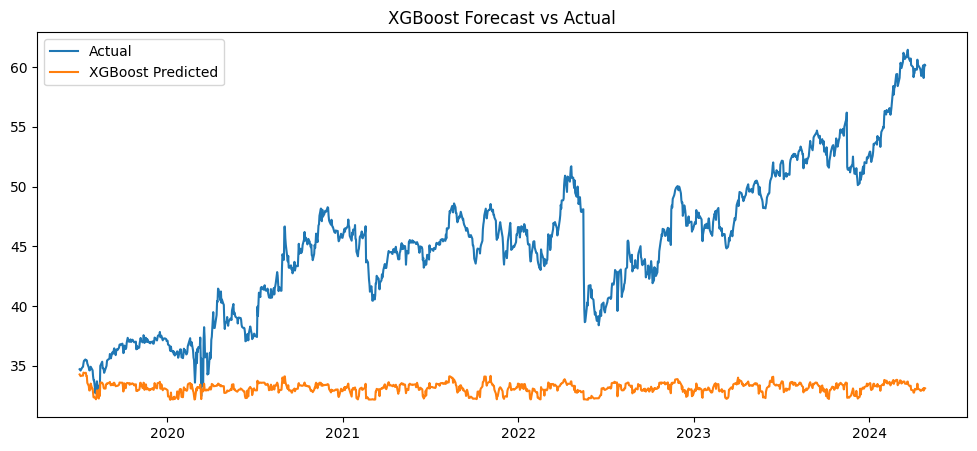

In [43]:
# 🧐 XGBOOST REGRESSOR: NEXT-DAY PRICE
# =========================
features = [col for col in walmart.columns if 'lag_' in col] + ['RSI', 'MACD', 'BB_upper', 'BB_lower', 'Day_num', 'Month_num', 'Weekday_num']
target = 'Adj Close'

X = walmart[features]
y = walmart[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train, y_train)

preds_xgb = xgb.predict(X_test)

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, preds_xgb, label='XGBoost Predicted')
plt.title('XGBoost Forecast vs Actual')
plt.legend()
plt.show()

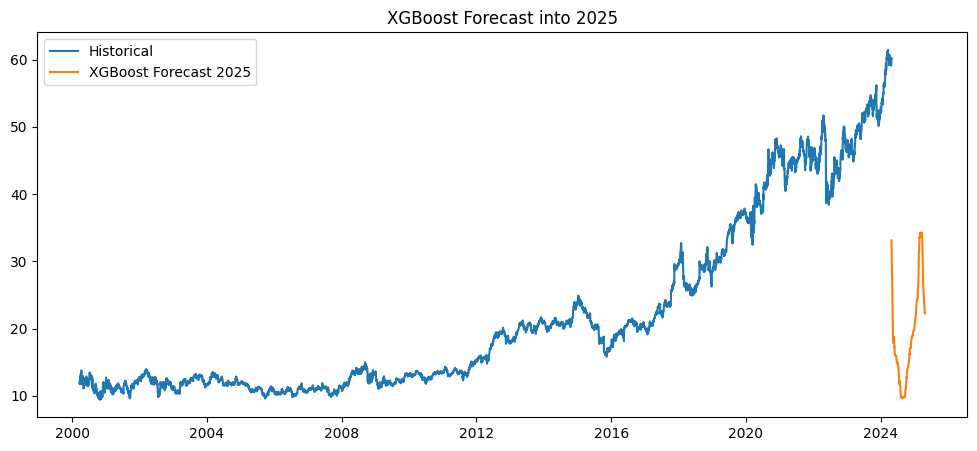

In [ ]:
# XGBOOST FORECAST INTO 2025 
future_days = 365
last_known = walmart.copy()
future_predictions = []

for i in range(future_days):
    last_row = last_known.iloc[-1:]
    new_date = last_row.index[0] + pd.Timedelta(days=1)
    row = {
        f"lag_{lag}": last_row['Adj Close'].values[0] for lag in range(1, 6)
    }
    for lag in range(1, 6):
        row[f"lag_{lag}"] = last_known['Adj Close'].iloc[-lag]
    row['RSI'] = RSIIndicator(last_known['Adj Close']).rsi().iloc[-1]
    row['MACD'] = MACD(last_known['Adj Close']).macd().iloc[-1]
    bb_future = BollingerBands(last_known['Adj Close'])
    row['BB_upper'] = bb_future.bollinger_hband().iloc[-1]
    row['BB_lower'] = bb_future.bollinger_lband().iloc[-1]
    row['Day_num'] = new_date.day
    row['Month_num'] = new_date.month
    row['Weekday_num'] = new_date.weekday()

    X_future = pd.DataFrame([row])
    pred = xgb.predict(X_future)[0]

    future_predictions.append((new_date, pred))
    new_row = pd.Series(pred, index=[new_date], name='Adj Close')
    last_known = pd.concat([last_known, pd.DataFrame({'Adj Close': new_row})])

future_xgb_df = pd.DataFrame(future_predictions, columns=['Date', 'Adj Close']).set_index('Date')

plt.figure(figsize=(12,5))
plt.plot(walmart['Adj Close'], label='Historical')
plt.plot(future_xgb_df, label='XGBoost Forecast 2025')
plt.title('XGBoost Forecast into 2025')
plt.legend()
plt.show()

In [45]:
import calendar
import plotly.express as px
import plotly.graph_objects as go

# Recalculate forecast length to end on 2025-12-31
last_date = walmart.index[-1]
forecast_start = pd.Timestamp('2025-01-01')
forecast_end = pd.Timestamp('2025-12-31')
days_to_forecast = (forecast_end - last_date).days

print(f"Forecasting {days_to_forecast} days from {last_date + pd.Timedelta(days=1)} to {forecast_end}")

# Forecast loop
last_known = walmart.copy()
future_predictions = []

for i in range(days_to_forecast):
    last_row = last_known.iloc[-1:]
    new_date = last_row.index[0] + pd.Timedelta(days=1)

    row = {f"lag_{lag}": last_known['Adj Close'].iloc[-lag] for lag in range(1, 6)}
    row['RSI'] = RSIIndicator(last_known['Adj Close']).rsi().iloc[-1]
    row['MACD'] = MACD(last_known['Adj Close']).macd().iloc[-1]
    bb = BollingerBands(last_known['Adj Close'])
    row['BB_upper'] = bb.bollinger_hband().iloc[-1]
    row['BB_lower'] = bb.bollinger_lband().iloc[-1]
    row['Day_num'] = new_date.day
    row['Month_num'] = new_date.month
    row['Weekday_num'] = new_date.weekday()

    X_future = pd.DataFrame([row])
    pred = xgb.predict(X_future)[0]
    future_predictions.append((new_date, pred))

    new_row = pd.Series(pred, index=[new_date], name='Adj Close')
    last_known = pd.concat([last_known, pd.DataFrame({'Adj Close': new_row})])

# Create DataFrame
future_df = pd.DataFrame(future_predictions, columns=['Date', 'Adj Close']).set_index('Date')

# Keep only 2025 data
future_2025 = future_df.reset_index()
future_2025 = future_2025[future_2025['Date'].dt.year == 2025]
future_2025['Month'] = future_2025['Date'].dt.month
future_2025['Month_Name'] = future_2025['Date'].dt.strftime('%B')


Forecasting 614 days from 2024-04-27 00:00:00 to 2025-12-31 00:00:00


In [46]:
fig_daily = px.line(
    future_2025, 
    x="Date", 
    y="Adj Close", 
    color="Month_Name",
    title="🔹 Daily Walmart Stock Price Forecast (2025)",
    labels={"Adj Close": "Predicted Adj Close", "Date": "Day"},
)

fig_daily.update_layout(
    xaxis_title="Date", 
    yaxis_title="Adjusted Close",
    legend_title="Month",
    xaxis=dict(
        tickformat="%b",  # Short month format
    )
)
fig_daily.show()


In [47]:
monthly_2025 = future_2025.groupby("Month_Name")['Adj Close'].mean().reindex(
    ["January", "February", "March", "April", "May", "June",
     "July", "August", "September", "October", "November", "December"]
)

fig_monthly = go.Figure()
fig_monthly.add_trace(go.Scatter(
    x=monthly_2025.index,
    y=monthly_2025.values,
    mode='lines+markers',
    name='Monthly Avg',
    line=dict(width=3)
))

fig_monthly.update_layout(
    title="📊 Monthly Average Walmart Stock Forecast (2025)",
    xaxis_title="Month",
    yaxis_title="Average Adj Close",
    xaxis=dict(tickmode='array', tickvals=monthly_2025.index),
)
fig_monthly.show()
